# Naive Bayes

## Write your id numbers and names here


1.   Etay Lorberboym - 314977596
2.   Peleg Gitnik - 208816827


## 1. Classifying Digits
In this part we will test digits classification on the MNIST dataset, using Bernoulli Naive Bayes (a generative model), in contrast to the Multivariate Logistic Regression (a discriminative model) we used before.

The MNIST dataset contains 28x28 grayscale images of handwritten digits between 0 and 9 (10 classes). For mathmatical analysis clarity, and for matching expected API, each image faltten to create a 1D array with 784 elements.

### Loading the MNIST dataset
Load the MNIST data set. The digits dataset is one of datasets scikit-learn comes with that do not require the downloading of any file from some external website. Use 
```
mnist = sklearn.datasets.fetch_mldata('MNIST original')
```
to fetch the original data. You may set the `data_home` to where you wish to download your data for caching. Each image is already transformed into a 1D integer array $x\in [0,255]^{784}$, and the corresponding label is an integer $y\in [0,9]$.

Plot a single sample of each digit as the original image, so you get a feeling how the data looks like.

Finally, divide your data into train and test sets, using 1/7 of the data for testing.

---
**Note 1:** Using `digits = sklearn.datasets.load_digits()` will only fetch a very small sample of the original set, with images resized to 8x8. This preprocessing of the data reduces dimensionality and gives invariance to small distortions - however, we will use the original data in this exercise. Feel free to test the proformance of the algorithms below on the preprocessed data as well.

**Note 2:**
Since ML-Data is deprecated, you may wish to use something like this:
>```
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], 784)
x_test = x_test.reshape(x_test.shape[0], 784)
```

####Importing Packages

Firstly, we will import the packages we need for each question in the assignment

In [19]:
#import packages for first question
import matplotlib.pyplot as plt
from keras.datasets import mnist
import numpy as np
import pandas as pd
from sklearn.naive_bayes import BernoulliNB , MultinomialNB
from sklearn.metrics import confusion_matrix, accuracy_score , classification_report
import sklearn.datasets
import seaborn as sns
from skimage.filters import threshold_mean

#import packages for second question
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer , TfidfVectorizer 
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator , ClassifierMixin
from sklearn.model_selection import learning_curve






Then after, we would want to download the mnist data and explore it.

In [20]:
#Loading data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [21]:
#shape of dataset
print('X_train: ' + str(x_train.shape))
print('Y_train: ' + str(y_train.shape))
print('X_test:  '  + str(x_test.shape))
print('Y_test:  '  + str(y_test.shape))

X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)


As we can see from the shape of the data, the data is already splitted for 6/7 trainning data (60000) and 1/7 testing data (10000).

We would want to plot the images for a better understanding.

We would plot the images from sklearn data set and also from the keras data set.

####Plotting the digits from Sklearn data set

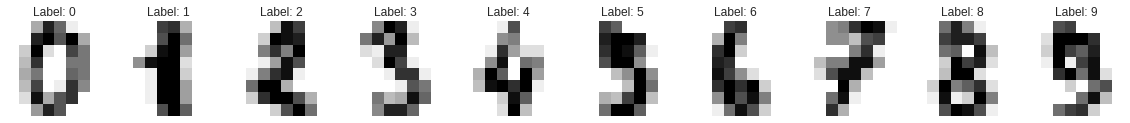

In [22]:
digits = sklearn.datasets.load_digits()

_, axes = plt.subplots(nrows=1, ncols=10, figsize=(20, 6))
for ax, image, label in zip(axes, digits.images, digits.target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title("Label: {}".format(label))

####Plotting the digits from Keras data set

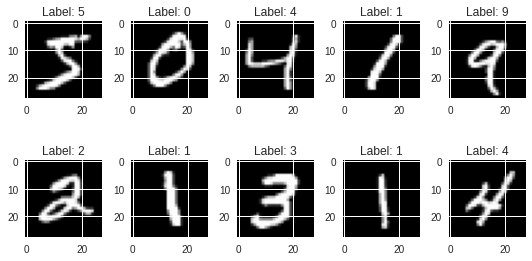

In [23]:
num = 10
images = x_train[:num]
labels = y_train[:15]

num_row = 2
num_col = 5# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(num):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(images[i], cmap='gray')
    ax.set_title('Label: {}'.format(labels[i]))
plt.tight_layout()
plt.show()

Lastly, as mentioned we would reshape each image in the data to (1,784) that we can work with it and run the model on it.

In [24]:
#changing shape to 1 array
x_train = x_train.reshape(x_train.shape[0], 784)
x_test = x_test.reshape(x_test.shape[0], 784)

In [25]:
#shape of dataset
print('X_train: ' + str(x_train.shape))
print('Y_train: ' + str(y_train.shape))
print('X_test:  '  + str(x_test.shape))
print('Y_test:  '  + str(y_test.shape))

X_train: (60000, 784)
Y_train: (60000,)
X_test:  (10000, 784)
Y_test:  (10000,)


###Preprocess Explanation
After we have explored the data we have received, it can be noticed that the data is divided into 10 classes which each class represents a digit from 0 to 9.
An image is divided into 28 by 28 pixels, and in order for us to work with it and run the algorithm we will make a dimension change so that we get a single vector with 784 Inputs.
So after the preprocess we get a a vector contains vector that each built by the 784 features. Each feature represents a pixel in an image and 10 classes for representing the digits, where each row is a representation of an image by all its pixels.

### Bernoulli Naive Bayes
If we know how the digits are generated, then we know how to classify them (simply choose the digit class which will maximize the posterior probability) --- but which model should we use for describing the digits generation?

In this part we will try a very simplified model of digits creation (which is obviously not the same as the "real" model), using a Naive Bayes over an underlying Bernoulli distribution --- that is, we will assume that given a digit class, the pixels of the images are the result of independent coin flips, each with its own "head" probability.

Note that since we assume each pixl is either 0 (black) or 1 (white), we will need to adjust (preprocess) our data accrodingly (see below).

So, the model is stated as follows:
$$
\begin{align}
\text{Domain} && x \in \{0,1\}^{784} \\
\text{Prior} && \pi_j = \Pr(y=j) \\
\text{Likelihood} && P_j(x) = \Pr(x | y=j) \\
\end{align}
$$

Where for each $i\in 0\ldots 784$ it holds that
$$
P_{ji}(x_i) = \Pr(x_i | y=j) =
\begin{cases}
p_{ji} & \text{if } x_i=1 \\
1-p_{ji} & \text{if } x_i=0 \\
\end{cases}
$$


#### Question 1
Write the classification rule based on this Naive Bayes model. 
How would you esitmate each of the parameters of the model based on the trainning data? 
Describe in text (preferably math notationns) the classification rule, and explain.

**Bonus:** Think of edge cases which may effect your estimator in an undesired way.

#### Answer 1

We would like to classify the images into the given classes by using the naive bayes algorithm which is based on Bayesian probability.

We using the Bernouli Naive bayes where we binarized the inputs to 0 and 1, where each value that is greater then 0 gets 1 and all the zeros stays the same.

We would like to find the probability that image $x_i$ belongs to class c given the image $x_i$ - the posterior of the model.

We model this question for the probability of

 $p (c | x) = p (c | p1,p2, ..., p784)$

Where x is a picture we want to identidy to one of the classes.

 Because we flatten the pixel vector we get a 28x28 vector of size 784 - p1,p1,...,p784 are the inputs (features) for each pixel where we can get the values between 0 to 1 (we binarized the pixels values).

 c is the class we want to identidy represent the pictures of numbers between 0 to 9.

Given image x, the probabilty of getting each of the classes is considered $p (c | x)$ so that the highest probability between the classes will be the value of the prediction, i.e.

$prediction (x) = argmax (p (c | x))$


Calculate $p (c | x)$ using the bayes law.

$posterior = \frac{Likelihood \cdot prior}{predictor} =   P(c | x) = \frac{P(x | c) \cdot p(c)}{p(x)} = \frac{P(x | c) \cdot p(c)}{\sum_{c}P(x | c) \cdot p(c)} $

We calculate $p(c)$ for each class, i.e. the probability that we will see group c in training data by counting appearances.
We count for each class how many times it appearance and divide by the total sum.

$Prior = P(c)$ = count(number of apperance of images digit) / count(total number of images)

We calculate the $likelihhod = p (x | c)$ by a naive assumption that the features (pixels p1, p2, .. p784) are independent and we can calculate the likelhood according to the formula for each c:

$ p(p_1,p_2,...,p_{784}|c) = p(p_1|c) \cdot p(p_2|c) \cdot \cdot \cdot p(p_{784}|c)$

This is why the model is naive, as in some cases there are features that are dependent.

we log this multipication to make the calculation easier (multipacation of a lot of probabilities will get a small value).

$log(p(p_1,p_2,...,p_{784}|c)) = log(p(p_1|c)) + log(p(p_2|c)) + \cdot \cdot  + log(p(p_{784}|c))$

$P(x)$ is constant for all values of c in $P(c|x)$ , so when we calcualte the argmax over it we can ignore $P(x)$.

We left with calculating the $argmax_cP(x|c)P(c)$



#### Question 2
Run a Naive Bayes classifier on the training data and apply predictions on the test data. Use the [sklearn.naive_bayes.BernoulliNB](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html) implementation (see the [source code for sklearn.naive_bayes](https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/naive_bayes.py) for details).

Remember we need to preprocess the data in this case such that each pixel would become either black (0) or white (1). For this, use the `binarize` parameter of the implementation. Set this value to $0$ (this is the default), which in this case would mean every pixel with non-zero value will be set to 1.

1. Plot the mean image of each class (estimated $\hat{p}_{ji}$) and generate one sample of each class (remember, you can do this since this is a generative model). You will need to access the `feature_log_prob_` attribute of the trained model.

2. Plot the confusion matrix of your classifier, as claculated on the test data (it is recommended to use [sklearn.metrics.confusion_matrix](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)). Calculate the total accuracy (fraction of correctly classified images), and summarize the results in your own words.

3. Think of a way you can find the optimal threshold of the binarization part. **There is no need to actually perform this task --- just describe what you would have done.**


#### Answer 2


###Running Bernouli Naive Bayes Model


In [26]:
nb_model = BernoulliNB(binarize = 0)
nb_model.fit(x_train,y_train)
predictions = nb_model.predict(x_test)

###1. Plotting Mean Image for each class

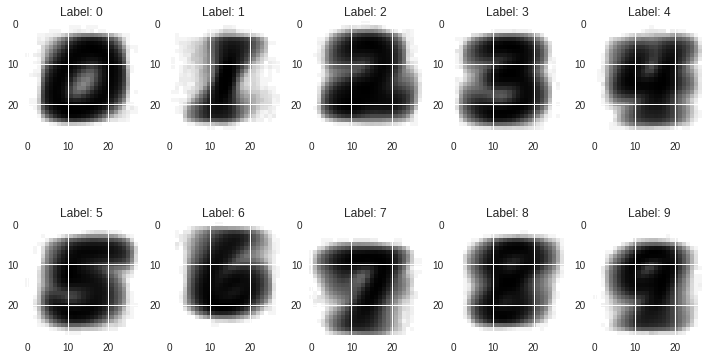

In [137]:
#ploting mean image of each class
num_row = 2
num_col = 5# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(2*num_col,3*num_row))
for i in range(len(nb_model.feature_log_prob_)):
    ax = axes[i//num_col, i%num_col]
    ax.set_title('Label: {}'.format(i))
    ax.imshow(nb_model.feature_log_prob_[i].reshape(28,28))
plt.tight_layout()
plt.show()

We can see from the plot each feature log probability for each class.
Y and X axis represent the pixels size.

###2. Calculating Confusion Matrix

In [28]:
cm = confusion_matrix(y_test, predictions)
print(f'Confusion Matrix result:\n{cm}')
print(f'\nAccuracy score: {accuracy_score(y_test, predictions)}\n')
print("Accuracy score for each predicted class:")
for c in range(len(cm)):
  print(f'Class({c}): {round(cm[c][c] / sum([j for j in [i for i in cm]])[c], 4)}')

Confusion Matrix result:
[[ 887    0    4    7    2   41   16    1   22    0]
 [   0 1085   10    5    0    9    6    0   19    1]
 [  19    8  852   29   17    4   32   14   55    2]
 [   5   15   34  844    0   13    9   15   49   26]
 [   2    6    4    0  795    4   21    1   23  126]
 [  23   12    7  129   30  627   16    8   21   19]
 [  18   18   15    2   13   35  851    0    6    0]
 [   1   24   14    4   15    0    0  871   27   72]
 [  16   23   13   76   17   22    7    6  758   36]
 [   9   13    5    9   74    8    0   24   24  843]]

Accuracy score: 0.8413

Accuracy score for each predicted class:
Class(0): 0.9051
Class(1): 0.9012
Class(2): 0.8894
Class(3): 0.7638
Class(4): 0.8255
Class(5): 0.8218
Class(6): 0.8883
Class(7): 0.9266
Class(8): 0.755
Class(9): 0.7493


**Explanation:**

We calculated the Confusion Matrix with the test's classes and the predictioned classes that returned from the classifier of our NB_Model. 
In this case we can see that the Matrix's results has got pretty good results, as we can see the big amount of classes we predicted successfully (on the diagonal). 
But despite that, we still can see specific cells that contain a big number of errors, for example when the classifier predicted class A instead of class B. It can help us to find some similarity between the classes or a specific misidentification that repeats itself. For example, in our Matrix, we can see 126 errors in the Matrix when the classifier predicted the number '9' instead of '4' (when the classifier succeeded 843 times to predict the number '9' correctly). From this example we can try to understand if there is a similarity between the visual look of the two numbers or that the classifier falls all the time in this case for a reason. 
By take a look at our results we can try to improve our model even more or making a decision about continuing to use the model (suspicion of non-compliance with our needs)!

For the accuracy measure we have got a score of: 84.13% Which measures the number of possitive results divided by all the results (possitive and negative results). In other words, accuracy checks how often is the classifier correct.

(Offhand remark: The more classes there are the less likely to predict correctly and can get a smaller value of accuracy).

###3. Optimize threshold of the binarization part

**Explanation:**

We thought of a way to improve the parameter of binarization by calculating the average pixel in each image.
In case the model can only have a single parameter for all the images, and there will be no possibility to use the threshold we found for each image then we will average the pixel averages in all the images and on that basis we will run the model.
We will run a simulation where will will find the mean threshold and compare it to the accuracy level where the binarization = 0

In [29]:
thresh_lst = []

for image in x_train:
  image.reshape(28,28)
  thresh = threshold_mean(image)
  thresh_lst.append(thresh)

thresh_avg = np.average(thresh_lst)

nb_model = BernoulliNB(binarize = thresh_avg)
nb_model.fit(x_train,y_train)
predictions2 = nb_model.predict(x_test)


In [30]:
print(f'Accuracy binarization = 0 : {accuracy_score(y_test, predictions)}')
print(f'Accuracy with average threshold : {accuracy_score(y_test, predictions2)}')
print(f'Average binarization threshold : {np.round(thresh_avg)}')


Accuracy binarization = 0 : 0.8413
Accuracy with average threshold : 0.8462
Average binarization threshold : 33.0


As we can see we recieve better accuracy score with a binarization parameter = 33 ( average threshold between all images).

Improvment by 0.49%

## 2. Classifing Text Documents using Multinomial Naive Bayes
In this exercise you will classify the "20 newsgroups" data set using your own naive bayes classifier and compare to the scikit learn built in version.

The 20 newsgroups dataset comprises around 18000 newsgroups posts on 20 topics split in two subsets: one for training (or development) and the other one for testing (or for performance evaluation). The split between the train and test set is based upon messages posted before and after a specific date.

### You task
Implement the barebone class provided: `NaiveBayes(BaseEstimator, ClassifierMixin)` and implement its `fit`, `predict` and `predict_proba` methods.

Then follow next anlysis guidlinnes using the implemented class for train and test classifier:
* Load the **train** data using `from sklearn.datasets import fetch_20newsgroups`. remove headers, footers and quotes (see documentation)
* Use `sklearn.feature_extraction.text import CountVectorizer` to count words (stop_words='english')
* use `sklearn.pipeline.make_pipeline` to chain the vectroizer and model.
* note: limit the vocuabolary size if you suffer memory issues
* compare the accuracy over the **test** data. You can use `accuracy_score, classification_report`
* compare to the built in `sklearn.naive_bayes.MultinomialNB`
* compare to `TfidfVectorizer` preprocessing (you can use the built in model for doing the analysis)
* plot the learning curve - is the model in the bias or variance regime (you can use the built in model for doing the analysis)
* optimize performance in respect to vectorizer hyper parameters (e.g. max_features, max_df etc.).


###Downloading the data

In [31]:
#Downloading data
data_train = fetch_20newsgroups(subset="train", remove = ('headers', 'footers', 'quotes'))
data_test = fetch_20newsgroups(subset="test", remove = ('headers', 'footers', 'quotes'))

#split to train data
x_train = data_train.data
y_train = data_train.target

#split to test data
x_test = data_test.data
y_test = data_test.target

###My Naive Bayes model

In [34]:
from sklearn.base import BaseEstimator, ClassifierMixin

class NaiveBayes(BaseEstimator, ClassifierMixin):
#BaseEstimator and ClassifierMixin are imported from sklearn.base

  def fit(self, x, y):

    #calculating prior - p(c)
    self.prior = np.bincount(y) / len(y)

    self.V = x.shape[1] #size of vocabulary
    num_of_docs = x.shape[0] # count of documents in x
    num_of_classes = len(self.prior)
    self.classes = {}
    doc_matrix = x.toarray()

    #running on all documnets
    for i in range(num_of_docs):

      curr_class = y[i] 
      curr_doc = doc_matrix[i]  

      #if class not in the class dict, add counter and words array
      if curr_class not in self.classes.keys():
        self.classes[curr_class] = [0, np.zeros(self.V)] #initial for each class [counter , vector of words]
  
      #iterate on all words in corpus and add to words dict
      for word in range(self.V):
        
        self.classes[curr_class][0] += curr_doc[word] # count(c)
        self.classes[curr_class][1][word] += curr_doc[word] #count(w,c)

    self.prob_dict = {}
    #creating P(w|c)
    for key in range(num_of_classes):
      self.prob_dict[str(key)] = (self.classes[key][1] + 1) / (self.classes[key][0] + self.V)


  def predict_log_proba(self, x):

      probs = []
      num_of_docs = x.shape[0]
      #iterate on all the test documents and check log proba for each class 
      for i in range(num_of_docs):
        log_prob = np.zeros(len(self.prior))

        for curr_class in range(len(self.prior)):
          p_c = self.prior[curr_class]
          
          mul_class = np.power(self.prob_dict[str(curr_class)], x[i])
          log_prob[curr_class] = np.sum(np.log(mul_class[mul_class!=0])) + np.log(p_c) 
        probs.append(log_prob)

      return probs

  def predict(self, x):
      probs = self.predict_log_proba(x.toarray())
      y_pred = []
      for i in range(x.shape[0]):
        y_pred.append(np.argmax(probs[i]))

      return y_pred

  
  

**Explanation for the model:**     

We implemented Multinomial Naive Bayes model for the data we recieved.

We implemented the function fit , predict_log_proba and predict.

In the fit function we calcualted $p(w|c)$.
 We used the formula of $p(w|c) = \frac{count(w,c) + 1} {count(c) + |V|} $ where
$count(w,c)$ is the count of apperances of a word in a specific class.

$count(c)$ - total number of words in class.

$ |V| $ - size of vocaublary.

We also calcualted $p(c) = \frac{N_c}{N} $ for the probability of a class in th data.

After we calculted the probability for a class and the probabilty of word in the document given the class in the fit function, we implement the predict_log_proba by calculating the probabilty of a class given the words in the document - $p(c|w) $ 

$p(c|w) = p(w|c) * p(c) $ for each class.

we calculated the log probabilty beacuse we get better results by doing it (as we explained in the questions before).

Lastly, we implement the predict function where we calculated the predicted class by doing argmax to find the class with the highest probabilty.









**notice - For all the model comparisons we reduced the feature size to 5000 because of memory issues.**

###Multinomial Naive Bayes model compared with CountVectorizer

#####Our Naive Bayes model

In [35]:
#Creating pipline for our Naive Bayes model with CountVectorizer
pipe = make_pipeline(CountVectorizer(stop_words='english', max_features= 5000), NaiveBayes())

#Fit pipline
pipe.fit(x_train,y_train)

#Make predictions
y_pred = pipe.predict(x_test)

#Accuracy score
print(f'Accuracy score: {accuracy_score(y_test, y_pred)}')


Accuracy score: 0.5939989378651088


####Sklearn Multinomial Naive Bayes model

In [36]:
#Creating pipline for Skelran Multinomial Naive Bayes model with CountVectorizer
pipe = make_pipeline(CountVectorizer(stop_words='english', max_features= 5000), MultinomialNB())

#Fit pipline
pipe.fit(x_train , y_train)

#Make predictions
y_pred = pipe.predict(x_test)

#Accuracy score
print(f'Accuracy score: {accuracy_score(y_test, y_pred)}')

Accuracy score: 0.5946627721720659


As we  can see while running the two models with the CounterVectorizer we recieved almost the same results of accuracy.
Our model recieved accuracy level of 59.39% where the sklearn model recieve the result of 59.46% - an 0.5% diffrence.

###Multinomial Naive Bayes model compared with TfidfVectorizer

#####Our Naive Bayes model

In [37]:
#Creating pipline for our Naive Bayes model with TfidfVectorizer
pipe = make_pipeline(TfidfVectorizer(stop_words='english', max_features= 5000), NaiveBayes())

#Fit pipline
pipe.fit(x_train,y_train)

#Make predictions
y_pred = pipe.predict(x_test)

#Accuracy score
print(f'Accuracy score: {accuracy_score(y_test, y_pred)}')


Accuracy score: 0.6505576208178439


####Sklearn Multinomial Naive Bayes model

In [38]:
#Creating pipline for Skelran Multinomial Naive Bayes model with TfidfVectorizer
pipe = make_pipeline(TfidfVectorizer(stop_words='english', max_features= 5000), MultinomialNB())

#Fit pipline
pipe.fit(x_train , y_train)

#Make predictions
y_pred = pipe.predict(x_test)

#Accuracy score
print(f'Accuracy score: {accuracy_score(y_test, y_pred)}')

Accuracy score: 0.6505576208178439


As we can see while running the two models with the TfidfVectorizer we recieved identical results of accuracy.
The two model have an accuracy level of 65%.

In [50]:
#Learning Curve

pipe = make_pipeline(CountVectorizer(stop_words='english'), MultinomialNB())

train_sizes, train_scores, test_scores = learning_curve(pipe, x_train, y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

When using the learning_curve function we downloaded the dat a

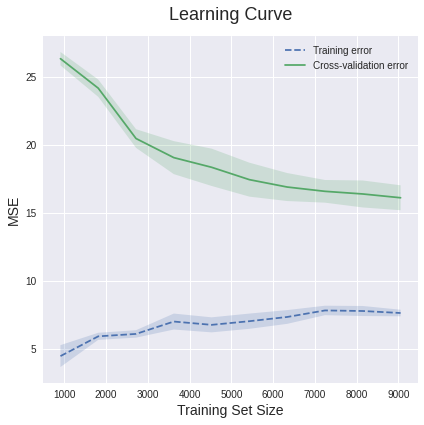

In [51]:

# Plotting:
plt.style.use('seaborn')
plt.subplots(1, figsize=(6,6))
plt.plot(train_sizes, -train_mean, '--',  label="Training error")
plt.plot(train_sizes, -test_mean, label="Cross-validation error")
plt.fill_between(train_sizes, -(train_mean - train_std), -(train_mean + train_std), alpha=0.2)
plt.fill_between(train_sizes, -(test_mean - test_std), -(test_mean + test_std), alpha=0.2)
plt.title("Learning Curve", fontsize = 18, y = 1.03)
plt.xlabel("Training Set Size", fontsize = 14), plt.ylabel("MSE", fontsize = 14), plt.legend(loc="best")
plt.tight_layout()
plt.show()

Learning Curve usually refers to a plot of the prediction error vs. the training set size - how better does the model get at predicting the target as you increase the number of instances used to train it and how the increase effects the model's performance. In order for us to say that a model performs well, we would like to see a model that trained on more data samples, that the error score of the cross-validation will decrease, the data training's error will stay pretty low and the error level of both training and validation sets will get closer to each other (good bias-variance trade-off). We wish for both training and cross-validation to get closer to each other and for some desired performance error score (with low error rate).

About the model's problematic forms:

Overfitting – the model is relevant only to the training set. In practice, the model doesn’t predict well other data sets (sees this data as irrelevant), in our case, the cross-validation set. Can point to a high variance between the training samples to the rest of the data.

Underfitting – isn’t a suitable model. It will be obvious as it will have poor performance on the training datasets and the rest of data sets (it happenes when the model is too simple and we need more complex model). Can point to a high bias. The data cannot fit the model.

Analysis: In this case, we used the built-in model (MultinomialNB) for measuring the performance of the model by looking at the Learning Curve's plot. We do that with the learning_curve() function of sklearn. We are showing the error of the training and validation sets adjustment to the number of samples. For scoring the error rate in our function, we wanted to use: MSE. But, because of the problem to score it (not a scoring parameter), we approximate it by using negative MSE and flipping the signs of y-axis when plotting. From the plot we got, we can see that our training error is low and the distance between the differences of the error values, as we increase the amount of samples in training, get closer, but does not seem to intend to get too close. From looking at this it can be understood that our model fits the data training pretty well (low training error) and that the cross-validation data has a higher error and differance between the error score - indicates a model that is closer to being overfitting than underfitting. This means we have a low bias and high variance. However, we still can see an improvement of the cross-validation score when adding more training samples and the progress with bigger training data growth changes (not too overfitting).

**Overall we got that the model is more inclined to a variance regime (even when the variance doesn't look that big).**

###Optimize Vectorizer parameters

In [62]:
#add code here
#Creating pipline for Multinomial Naive Bayes model with CountVectorizer
pipe = make_pipeline(CountVectorizer(stop_words='english',max_df = 500,min_df = 2 ), MultinomialNB())

#Fit pipline
pipe.fit(x_train , y_train)

#Make predictions
y_pred = pipe.predict(x_test)

#Accuracy score
print(f'Accuracy score: {accuracy_score(y_test, y_pred)}')

Accuracy score: 0.6609134360063728


As we can see while tuning the parameters we succedded to get better results.
with max_df = 500 and min__df = 2 we get accuracy of 66%.

We improved the model by 2.6% (66% - 63.4%).


### Bonus I (5 points)
#### Model interpretability
Find the most important features for a **specific** decision of a NB classifier.
Because the model has learned the prior $p(x_i|c)$ during the training, the contribution of an individual feature value can be easily measured by the posterior, $p(c|x_i)=p(c)p(x_i|c)/p(x_i)$
Implement a function which gets a scikit-learn NB model as input and returns $P(c|x_i)$:

`def calc_p_c_given_xi(model)`

Hint: Use the following model properties:

* `model.class_log_prior_`
* `model.feature_log_prob_`

Note: remember these are logs and you need to use np.exp and normalize to get $P(c|x_i)$ 
Another hint: use numpy built-in broadcasting property.

* Use the interpretation to examine errors of the classifier where $\hat{c}\ne c$. Which top words support the correct class and which support the wrong class? You can use the `print_txt` below to color words.

In [155]:
import string
def print_txt(txt, hot, cold):
  """
  print the text, coloring hot and cold words with colors
  """
  cold_color='\x1b[41;37m{}\x1b[0m'
  hot_color='\x1b[42;37m{}\x1b[0m'
  def color(token):
    lower = str(token).lower()
    lower = lower.replace('\t','').replace('\n','')
    lower = lower.translate(string.punctuation)
    if (lower in hot) and (lower in cold):
      return mid_color.format(token)
    elif lower in hot:
      return hot_color.format(token)
    elif lower in cold:
      return cold_color.format(token)
    else:
      return token
  colored_txt = " ".join([color(token) for token in txt.split(' ')])
  print(colored_txt)
print_txt('This word support the first class but this the other', ['word'],['other'])

This word support the first class but this the other


In [199]:
# Implementationn for 1st bonus
def calc_p_c_given_xi(model):

  #get log probability for the features and the prior and using exponent to extract the probabilty of them
  log_priors = model.class_log_prior_
  priors = np.exp(log_priors) # p(c)
  
  f_log_proba = model.feature_log_prob_
  f_proba = np.exp(f_log_proba) # p(w|c) - likelihood

  #calculating p(x_i)
  p_xi = np.multiply(priors,f_proba.T)
  p_x = np.sum(p_xi)

  probs = [] # result

  for i in range(len(priors)): # calculate probabilty for each word -> p(x_i | c) * p(c) 
    probs.append(priors[i]*f_proba[i]/p_x)

    return probs

In [203]:
#setting new pipe
pipe = make_pipeline(TfidfVectorizer(stop_words='english', max_features= 5000), MultinomialNB())
pipe.fit(x_train, y_train)

#extracting model
model = pipe.get_params()['multinomialnb']

#extracting the features names
features_names = pipe.get_params()['tfidfvectorizer'].get_feature_names_out()

#setting a list for the hot and cold words for the print_txt function
hot_words = set()
cold_words = set()

#using the function we built to calculate the probabilities
probs = calc_p_c_given_xi(model)

#calculating the mean thresh for separating hot and cold words
mean_thresh_lst = []
for p in probs:
  mean_thresh_lst.append(np.average(p))
mean_thresh = np.average(mean_thresh_lst)

#separting the words by each word probabilty
for i in range(len(probs)):
  for j in range(len(probs[i])):
    p_w = probs[i][j]
    if p_w < mean_thresh:
      cold_words.add(names[j])
    else:
      hot_words.add(names[j])
    


In [204]:
print_txt(x_train[24], hot_words, cold_words)

I don't know about the specific problem mentioned in your
message, but I definitely had SCSI problems between my
Q700 and my venerable Jasmine Megadrive 10 cartridge
drives.  My solution was to get Silverlining.  None of
the loops that involved blind writes worked to the drives;
in fact the only loop that worked was the "Macintosh
Software" loop (whatever that means).


When we use the function we get the affect by the probability of each word in a document.
We classify by a mean threshold of all the probabilities for all the document so we can classify for hot and cold words.

### Bonus II (5 points)
#### How can you correct the analyzed error?

To read more about model interpretation, see the blogpost below and the tutorial:
* https://lilianweng.github.io/lil-log/2017/08/01/how-to-explain-the-prediction-of-a-machine-learning-model.html
* https://github.com/chanansh/right_but_why

Answer for 2nd bonus

There are several ways we can correct the analyzed error after running it.
As we did it bonus 1 we can get the features affect by calculating the posterior and choose only features that are affecting our model more then others.

Furthermore, We can try to affect the variance - bias tradeoff by tuning the paramethers of the model.

We can try to collect more data to get a bigger sample size for a better accuracy.

Lastly, we can try add more undepended parameters for the model and try to see if the new model gets better results.


